In [35]:
%pylab inline
import os 
import json
import pandas as pd
import torch
import sagemaker
from tqdm import tqdm
from datasets import load_dataset, Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, TrainingArguments, Trainer, T5ForConditionalGeneration,T5Tokenizer
from sagemaker.huggingface import HuggingFace

# if running on GPU instance, enable Torch, otherwise use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# specify execution role
#role = sagemaker.get_execution_role()
# specify bucket
bucket = 'sagemaker-eu-west-1-177767430422'

Populating the interactive namespace from numpy and matplotlib


Need to look at scale of win for clickthrough 

can try using classification and embeddings

Should generate embeddings for each headline version and then do some clustering. Visualize the embeddings and look for patterns.

Can try using GPT-2 instead of the squeezebert model 

In [36]:
headlines = pd.read_csv('ars-headline-tests-no-filter.csv')
headlines['title_rate_diff'] = np.abs(headlines.title_a_rate-headlines.title_b_rate)
label = []
for i,row in headlines.iterrows():
#     if row['title_rate_diff']<0.01:
#         label.append(2)
    if row['winner']=='a':
        label.append(0)
    else:
        label.append(1)
headlines['label'] = label
headlines.head()

,ID,post_date,title_a,title_b,title_a_impressions,title_b_impressions,title_a_clicks,title_b_clicks,title_a_rate,title_b_rate,winner,confidence,title_rate_diff,label
0,1774776,6/20/2021 6:01:24 PM,Porsche will build a high-performance battery ...,Porsche is building a battery factory for moto...,1060,1005,65,50,0.0613,0.0498,a,0,0.0115,0
1,1774704,6/21/2021 6:00:57 AM,Sony’s excellent WH-1000XM4 headphones are dow...,A couple of our favorite wireless headphones a...,788,826,82,66,0.1041,0.0799,a,95,0.0242,0
2,1774658,6/21/2021 4:50:03 AM,Amazon Prime Day 2021: All the deals that are ...,Amazon Prime Day 2021: A mega-roundup of all t...,677,610,81,69,0.1196,0.1131,a,0,0.0065,0
3,1774623,6/20/2021 5:18:52 PM,Review: <em>Hitman’s Wife’s Bodyguard</em> amp...,<em>The Hitman’s Wife’s Bodyguard</em> is the ...,846,830,82,139,0.0969,0.1675,b,100,0.0706,1
4,1774586,6/18/2021 9:43:09 AM,"Pornhub hosted rape, revenge porn, and child s...","Pornhub sued for allegedly serving “under-age,...",1658,1676,177,214,0.1068,0.1277,b,97,0.0209,1


(array([4926.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        5771.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <a list of 10 Patch objects>)

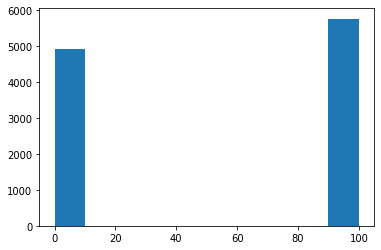

In [37]:
# plot confidence
plt.hist(headlines.confidence)

In [38]:
# save headlines with rate above 0.01
headlines[headlines.title_rate_diff>0.01].to_csv('sig_diff_headlines.csv', index=False)
headlines.to_csv('formatted_headlines.csv', index=False)

In [32]:
# get summary stats on headline title rate differential
print('max:',np.max(headlines.title_rate_diff))
print('mean:', np.mean(headlines.title_rate_diff))
print('Number of observations above 1%:',sum(headlines.title_rate_diff>0.01))

max: 197.8429
mean: 0.04461947200898713
Number of observations above 1%: 7057


(array([3.625e+03, 2.548e+03, 1.705e+03, 1.036e+03, 6.540e+02, 3.930e+02,
        2.550e+02, 1.560e+02, 9.900e+01, 5.200e+01, 4.400e+01, 1.800e+01,
        1.900e+01, 1.400e+01, 1.500e+01, 6.000e+00, 5.000e+00, 2.000e+00,
        3.000e+00, 4.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

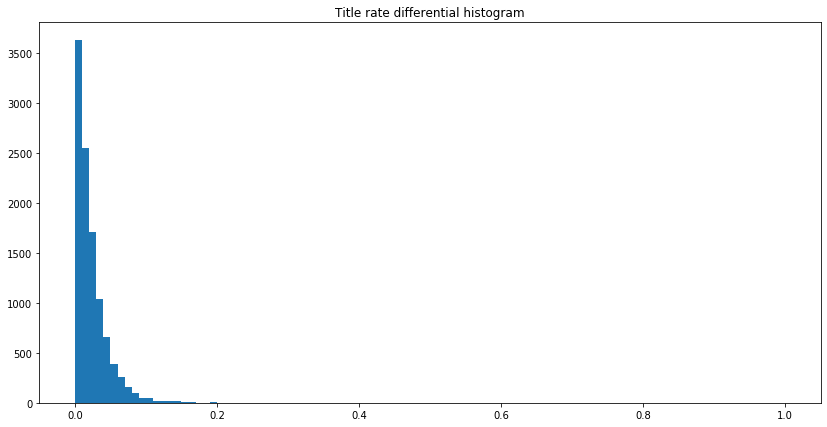

In [39]:
# plot histogram of rate differential
plt.figure(figsize=(14,7))
plt.title('Title rate differential histogram')
plt.hist(headlines.title_rate_diff, bins=100, range=(0,1))

In [40]:
# send data to s3
!aws s3 cp formatted_headlines.csv s3://{bucket}/headlines/formatted_headlines.csv
!aws s3 cp sig_diff_headlines.csv s3://{bucket}/headlines/sig_diff_headlines.csv

upload: ./formatted_headlines.csv to s3://sagemaker-eu-west-1-177767430422/headlines/formatted_headlines.csv
upload: ./sig_diff_headlines.csv to s3://sagemaker-eu-west-1-177767430422/headlines/sig_diff_headlines.csv


## Paraphrase model 
Can use this as a base for how to setup our task.

In [41]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased-finetuned-mrpc")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased-finetuned-mrpc")

classes = ["not paraphrase", "is paraphrase"]

sequence_0 = "The company HuggingFace is based in New York City"
sequence_1 = "Apples are especially bad for your health"
sequence_2 = "HuggingFace's headquarters are situated in Manhattan"

paraphrase = tokenizer.encode_plus(sequence_0, sequence_2, return_tensors="pt")
not_paraphrase = tokenizer.encode_plus(sequence_0, sequence_1, return_tensors="pt")

paraphrase_classification_logits = model(**paraphrase)[0]
not_paraphrase_classification_logits = model(**not_paraphrase)[0]

paraphrase_results = torch.softmax(paraphrase_classification_logits, dim=1).tolist()[0]
not_paraphrase_results = torch.softmax(not_paraphrase_classification_logits, dim=1).tolist()[0]

print("Should be paraphrase")
for i in range(len(classes)):
    print(f"{classes[i]}: {round(paraphrase_results[i] * 100)}%")

print("\nShould not be paraphrase")
for i in range(len(classes)):
    print(f"{classes[i]}: {round(not_paraphrase_results[i] * 100)}%")

Should be paraphrase
not paraphrase: 10%
is paraphrase: 90%

Should not be paraphrase
not paraphrase: 94%
is paraphrase: 6%


## Load model locally

We can try several models to finetune, the squeezebert model works relatively well, more powerful models like GPT-2 will likely work even better. We are focusing on models pretrained on large amounts of news text.

In [42]:
# load model
model_checkpoint = 'squeezebert/squeezebert-mnli-headless'
# "Michau/t5-base-en-generate-headline"
# QianWeiTech/GPT2-News
# squeezebert/squeezebert-mnli-headless
# in order to use any of these models we need to have a tokenizer.
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

# number of output labels
num_labels = 2
# while the original model was trained in a "masked language model" format, we can finetune it for a different task, in this case sequence classification
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)
# send model to GPU
model.to(device)

Some weights of SqueezeBertForSequenceClassification were not initialized from the model checkpoint at squeezebert/squeezebert-mnli-headless and are newly initialized: ['transformer.pooler.dense.weight', 'classifier.weight', 'classifier.bias', 'transformer.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


SqueezeBertForSequenceClassification(
  (transformer): SqueezeBertModel(
    (embeddings): SqueezeBertEmbeddings(
      (word_embeddings): Embedding(30528, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): SqueezeBertEncoder(
      (layers): ModuleList(
        (0): SqueezeBertModule(
          (attention): SqueezeBertSelfAttention(
            (query): Conv1d(768, 768, kernel_size=(1,), stride=(1,), groups=4)
            (key): Conv1d(768, 768, kernel_size=(1,), stride=(1,), groups=4)
            (value): Conv1d(768, 768, kernel_size=(1,), stride=(1,), groups=4)
            (dropout): Dropout(p=0.1, inplace=False)
            (softmax): Softmax(dim=-1)
            (matmul_qk): MatMulWrapper()
            (matmul_qkv): MatMulWrapper()
          )
          (post_attention): ConvDr

## Format our data

To use HF for training we need to put our data into their format. Here we are loading our CSV file and then we will tokenize the inputs so the model can training on it.

In [43]:
# load labels as HF dataset
dataset = load_dataset('csv', data_files='formatted_headlines.csv') # 'ars-headline-tests-no-filter.csv')
# eval_dataset = load_dataset('csv', data_files='eval_frame.csv')
dataset

Using custom data configuration default-af6c617adf595a0f


Dataset csv downloaded and prepared to /home/sean/.cache/huggingface/datasets/csv/default-af6c617adf595a0f/0.0.0/e138af468cb14e747fb46a19c787ffcfa5170c821476d20d5304287ce12bbc23. Subsequent calls will reuse this data.


DatasetDict({
    train: Dataset({
        features: ['ID', 'post_date', 'title_a', 'title_b', 'title_a_impressions', 'title_b_impressions', 'title_a_clicks', 'title_b_clicks', 'title_a_rate', 'title_b_rate', 'winner', 'confidence', 'title_rate_diff', 'label'],
        num_rows: 10697
    })
})

In [12]:
# if using GPT2 need to add PAD token
# tokenizer.add_special_tokens({'pad_token': '[PAD]'})
# tokenizer(text=dataset['train']['title_a'][0],text_pair = dataset['train']['title_b'][0], truncation=True, max_length=512, padding='max_length')


In [44]:
# run example tokenization 
print(dataset['train']['title_a'][0], '\n',dataset['train']['title_b'][0], '\n')
tokens = tokenizer.encode_plus(text=dataset['train']['title_a'][0],text_pair = dataset['train']['title_b'][0], truncation=True, padding='max_length')
print(tokens)

Porsche will build a high-performance battery factory in Germany 
 Porsche is building a battery factory for motorsport and performance EVs 

{'input_ids': [101, 16099, 2097, 3857, 1037, 2152, 1011, 2836, 6046, 4713, 1999, 2762, 102, 16099, 2003, 2311, 1037, 6046, 4713, 2005, 21044, 1998, 2836, 23408, 2015, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [15]:
# tokenize your inputs 
input_ids = []
token_type_ids = []
attention_masks = []
label = []
for i in tqdm(range(len(dataset['train']))):
    token = tokenizer.encode_plus(dataset['train']['title_a'][i],dataset['train']['title_b'][i], truncation=True, padding='max_length')
    input_ids.append(np.array(token['input_ids'], dtype=np.int32))
    token_type_ids.append(np.array(token['token_type_ids'], dtype=np.int32))
    attention_masks.append(np.array(token['attention_mask'], dtype=np.int32))
    label.append(dataset['train']['label'][i])

100%|██████████| 10697/10697 [06:03<00:00, 29.44it/s]


In [17]:
# define our split
split_ind = int(.95*len(dataset['train']))
# reform datasets into two separate dictionaries 
dataset_dict = {}
eval_dataset_dict = {}
dataset_dict['input_ids'] = input_ids[:split_ind]
dataset_dict['token_type_ids'] = token_type_ids[:split_ind]
dataset_dict['attention_mask'] = attention_masks[:split_ind]
dataset_dict['label'] = label[:split_ind]

eval_dataset_dict['input_ids'] = input_ids[split_ind:]
eval_dataset_dict['token_type_ids'] = token_type_ids[split_ind:]
eval_dataset_dict['attention_mask'] = attention_masks[split_ind:]
eval_dataset_dict['label'] = label[split_ind:]

Having issues with max length...

ArrowInvalid: Column 1 named attention_mask expected length 697 but got length 1000

In [ ]:
# # try to use HF dataset mapper, had issues with implementation
# def encode(examples, tokenizer):
# #     print(examples['title_a'])
#     print(examples['title_a'][0], examples['title_b'][0])
#     return tokenizer.encode_plus(str(examples['title_a'][0][:]), str(examples['title_b'][0][:]), truncation=True, padding='max_length', max_length=384) # 'max_length'

# dataset = dataset.map(encode, batched=True, fn_kwargs={'tokenizer':tokenizer})
# # eval_dataset = eval_dataset.map(encode, batched=True, fn_kwargs={'tokenizer':tokenizer})
# columns_to_return = ['input_ids', 'label', 'attention_mask']
# dataset.set_format(type='torch', columns=columns_to_return)
# eval_dataset.set_format(type='torch', columns=columns_to_return)

Create train and eval sets

In [18]:
# create dataset objects from previously created dictionaries 
train_dataset = Dataset.from_dict(dataset_dict)
eval_dataset = Dataset.from_dict(eval_dataset_dict)
columns_to_return = ['input_ids', 'label', 'attention_mask']
train_dataset.set_format(type='torch', columns=columns_to_return) #, device='cuda')
eval_dataset.set_format(type='torch', columns=columns_to_return) #, device='cuda')
train_dataset

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    num_rows: 10162
})

In [239]:
# set evaluation function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

## Run training locally

If you are using a GPU instance you can run training locally.

In [249]:
# run training locally
batch_size = 8
metric_name = "accuracy"
args = TrainingArguments(
    "test-glue",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=2,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
)

# it automatically tries to create tensors for you
# validation_key = "validation_mismatched" if task == "mnli-mm" else "validation_matched" if task == "mnli" else "validation"
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
#     tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

Run training:

In [ ]:
trainer.train()

In [158]:
# all samples results
trainer.evaluate(eval_dataset=eval_dataset)

{'eval_loss': 0.695730447769165,
 'eval_accuracy': 0.702,
 'eval_f1': 0.7019361060880048,
 'eval_precision': 0.7018778391154427,
 'eval_recall': 0.702,
 'eval_runtime': 12.0364,
 'eval_samples_per_second': 41.541,
 'epoch': 3.0,
 'eval_mem_cpu_alloc_delta': 622592,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_cpu_peaked_delta': 0,
 'eval_mem_gpu_peaked_delta': 289534464}

In [180]:
# only significant winner dataset
trainer.evaluate(eval_dataset=eval_dataset)

{'eval_loss': 0.5558859705924988,
 'eval_accuracy': 0.786,
 'eval_f1': 0.7870509308975953,
 'eval_precision': 0.7949385560675882,
 'eval_recall': 0.786,
 'eval_runtime': 12.6321,
 'eval_samples_per_second': 39.582,
 'epoch': 3.0,
 'eval_mem_cpu_alloc_delta': -20480,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_cpu_peaked_delta': 20480,
 'eval_mem_gpu_peaked_delta': 289534464}

All samples have 70% accuracy in validation
Only significant winner samples have 78% accuracy in validation 

Evaluate on the same holdout set. Can try reducing the learning rate. 

## Run in SageMaker Training

To run the same thing in sagemaker training we can use the following code. We first define our metrics to be collected, then define and launch our estimator. 

In [ ]:
# define metrics to track
metric_definitions=[{
        "Name": "loss",
        "Regex": ".*loss:\s([0-9\\.]+)\s*"
    },
    {
        "Name": "eval_loss",
        "Regex": ".*eval_loss:\s([0-9\\.]+)\s*"
    },
    {
        "Name": "eval_accuracy",
        "Regex": ".*eval_accuracy:\s([0-9\\.]+)\s*"
    },
    {
        "Name": "eval_f1",
        "Regex": ".*eval_f1:\s([0-9\\.]+)\s*"
    },
    {
        "Name": "eval_precision",
        "Regex": ".*eval_precision:\s([0-9\\.]+)\s*"
    }, 
    {
        "Name": "learning_rate",  
        "Regex": ".*learning_rate:\s([0-9\\.]+)\s*"
    },
    {
        "Name": "eval_recall",  
        "Regex": ".*eval_recall:\s([0-9\\.]+)\s*"
    }
]

In [262]:
hyperparameters = {
	'model_name':'squeezebert/squeezebert-mnli-headless',
	'output_dir':'/opt/ml/model',
    'num_labels':2,
    'epochs':2
    
	# add your remaining hyperparameters
	# more info here https://github.com/huggingface/transformers/tree/v4.4.2/examples/text-classification
}

# git configuration to download our fine-tuning script
git_config = {'repo': 'https://github.com/huggingface/transformers.git','branch': 'v4.4.2'}

# creates Hugging Face estimator
huggingface_estimator = HuggingFace(
	entry_point='train.py',
	source_dir='container_training', #'./examples/text-classification',
	instance_type='ml.p3.2xlarge',
	instance_count=1,
	role=role,
# 	git_config=git_config,
	transformers_version='4.4.2',
	pytorch_version='1.6.0',
	py_version='py36',
	hyperparameters = hyperparameters,
    metric_definitions=metric_definitions
)

# starting the train job
job_name = 'hf-headline-class-test'
huggingface_estimator.fit(inputs = {'train':f's3://{bucket}/headlines/formatted_headlines.csv'}, 
                          wait=False,
                         job_name = job_name)

In [ ]:
# for hyperparameter tuning
trainer.hyperparameter_search(
    direction="maximize", 
    backend="ray", 
    n_samples=10, # number of trials
    # n_jobs=2  # number of parallel jobs, if multiple GPUs
)

In [ ]:
# models
# Michau/t5-base-en-generate-headline
# mrm8488/t5-base-finetuned-summarize-news

# ktrapeznikov/gpt2-medium-topic-news
# mrm8488/bert-mini-finetuned-age_news-classification

# QianWeiTech/GPT2-News
